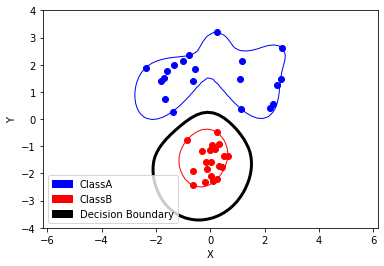

In [1]:
import numpy as np
from scipy.optimize import minimize
import random, math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Generate Data
def generateData():
    classA = np.concatenate((
        np.random.randn(10, 2) * 0.8 + [1.5, 1.5],
        np.random.randn(10, 2) * 0.8 + [-1.5, 1.5]))

    classB = np.random.randn(20, 2) * 0.5 + [0.0, -1.5]

    # Plotting
    pA = plt.plot([p[0] for p in classA], [p[1] for p in classA], 'bo')
    pB = plt.plot([p[0] for p in classB], [p[1] for p in classB], 'ro')

    inputs = np.concatenate((classA, classB))
    targets = np.concatenate(
        (np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

    N = inputs.shape[0]

    permute = list(range(N))
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]

    return inputs, targets, N


# Kernel Functions
def kernel(x, y, *type):
    x_t = np.transpose(x)
    y_t = np.transpose(y)
    if type == 'linear':
        return np.dot(x_t, y)
    elif type == 'polynomial':
        return math.pow(np.dot(x_t, y) + 1, 1)
    elif type == 'polynomial4':
        return math.pow(np.dot(x_t, y) + 1, 5)
    else:
        return math.exp(-np.linalg.norm(x - y, 2) ** 2 / (2. * 1 ** 2))


# Compute P Matrix
def matrix(inputs, targets, N):
    M = []
    for i in range(N):
        A = []
        for j in range(N):
            k = kernel(inputs[i], inputs[j], 'linear')
            p = targets[i] * targets[j] * k
            A.append(p)
        M.append(np.array(A))
    return np.array(M)


def zerofun(alpha):
    return np.dot(alpha, targets)


def objective(alpha):
    return (1 / 2) * np.dot(alpha, np.dot(alpha, PCM)) - np.sum(alpha)


def extractNonZeros(alpha):
    alpha_nonzero = []
    inputs_nonzero = []
    targets_nonzero = []
    for i in range(N):
        if (alpha[i] > 10 ** -5):
            alpha_nonzero.append(alpha[i])
            inputs_nonzero.append(inputs[i])
            targets_nonzero.append(targets[i])
    return alpha_nonzero, inputs_nonzero, targets_nonzero


# Compute b
def calculateB():
    s = inputs_nonzero[0]
    ts = targets_nonzero[0]

    sum_b = 0
    for i in range(N):
        sum_b += alpha[i] * targets[i] * kernel(s, inputs[i], 'linear')

    return sum_b - ts


# Classify using indicator function
def indicator():
    ans = []
    for si in range(len(alpha)):
        sm = 0
        for i in range(len(alpha)):
            sm += alpha[i] * targets[i] * kernel(inputs[si], inputs[i], 'linear')
        sm -= b
        ans.append(sm)

    return ans


def sIndicator(sv):
    sm = 0
    for i in range(len(alpha)):
        sm += alpha[i] * targets[i] * kernel(sv, inputs[i], 'linear')
    sm -= b
    return sm


inputs, targets, N = generateData()
PCM = matrix(inputs, targets, N)

start = np.zeros(N)  # N is the number of training samples
C = 10000

# To have an upper constraint
B = [(0, C) for b in range(N)]

# To only have a lower bound:
# B = [(0, None) for b in range(N)]

# XC is the second half of equation 10; given as a dictionary with fields type and fun
# In the following example, zerofun is a function which calculates the value which
# ...should be constrained to zero.
XC = {'type': 'eq', 'fun': zerofun}

ret = minimize(objective, start, bounds=B, constraints=XC)
alpha = ret['x']

# Extract Nonzero Values of alpha
alpha_nonzero, inputs_nonzero, targets_nonzero = extractNonZeros(alpha)

# Calculate B
b = calculateB()

# Classify using indicator
ans = indicator()

goodClassA = []
goodClassB = []
for i in range(len(targets_nonzero)):
    if targets_nonzero[i] < 0:
        goodClassA.append(inputs_nonzero[i])
    else:
        goodClassB.append(inputs[i])
# pA = plt.plot([p[0] for p in goodClassA], [p[1] for p in goodClassA],'bo')
# pB = plt.plot([p[0] for p in goodClassB], [p[1] for p in goodClassB],'ro')


xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-4, 4)

grid = np.array([[sIndicator(np.array([x, y])) for x in xgrid] for y in ygrid])

plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0),
            colors=('red', 'black', 'blue'),
            linewidths=(1, 3, 1))

blue_patch = mpatches.Patch(color='blue', label='ClassA')
red_patch = mpatches.Patch(color='red', label='ClassB')
black_patch = mpatches.Patch(color='black', label='Decision Boundary')
plt.legend(handles=[blue_patch, red_patch, black_patch])

plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()


